In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import KernelPCA

In [52]:
kpca = KernelPCA(
    n_components = 3,
    kernel = "rbf",
    gamma = 0.1,
    fit_inverse_transform = True,
    alpha = 1.0,
    )

(1000, 2)

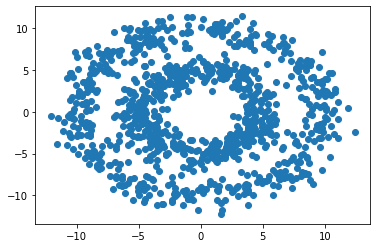

In [53]:
M = 1000
N = 2
rho1 = 5 + np.random.normal(scale = 1, size = M // 2)
rho2 = 10 + np.random.normal(scale = 1, size = M // 2)
rho = np.concatenate((rho1, rho2))
phi = np.random.uniform(0.0, 2 * np.pi, size = M)
x = rho * np.cos(phi)
y = rho * np.sin(phi)
data = np.stack((x, y), axis = -1)
plt.scatter(x, y)
data.shape

In [54]:
kpca.fit(data)

KernelPCA(fit_inverse_transform=True, gamma=0.1, kernel='rbf', n_components=3)

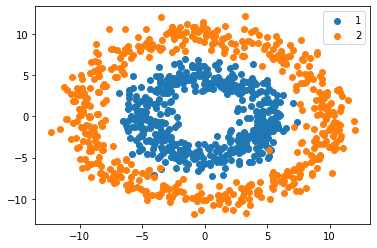

In [55]:
rho_1 = 5 + np.random.normal(scale = 1, size = M // 2)
phi_1 = np.random.uniform(0.0, 2 * np.pi, size = M // 2)
data_1 = np.stack((rho_1 * np.cos(phi_1), rho_1 * np.sin(phi_1)), axis = -1)
rho_2 = 10 + np.random.normal(scale = 1, size = M // 2)
phi_2 = np.random.uniform(0.0, 2 * np.pi, size = M // 2)
data_2 = np.stack((rho_2 * np.cos(phi_2), rho_2 * np.sin(phi_2)), axis = -1)
plt.scatter(data_1[:, 0], data_1[:, 1], label = "1")
plt.scatter(data_2[:, 0], data_2[:, 1], label = "2")
plt.legend()

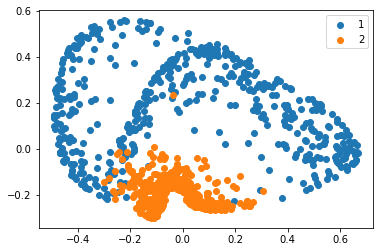

In [56]:
data_pca_1 = kpca.transform(data_1)
data_pca_2 = kpca.transform(data_2)
plt.scatter(data_pca_1[:, 1], data_pca_1[:, 2], label = "1")
plt.scatter(data_pca_2[:, 1], data_pca_2[:, 2], label = "2")
plt.legend()

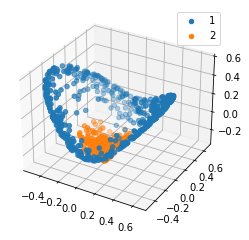

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data_pca_1[:, 0], data_pca_1[:, 1], data_pca_1[:, 2], label = "1")
ax.scatter(data_pca_2[:, 0], data_pca_2[:, 1], data_pca_2[:, 2], label = "2")
plt.legend()

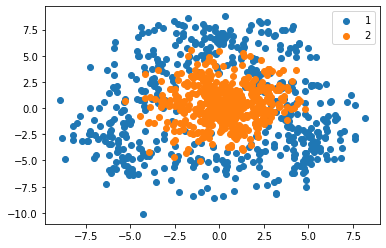

In [58]:
data_1_inv = kpca.inverse_transform(data_pca_1)
data_2_inv = kpca.inverse_transform(data_pca_2)
plt.scatter(data_1_inv[:, 0], data_1_inv[:, 1], label = "1")
plt.scatter(data_2_inv[:, 0], data_2_inv[:, 1], label = "2")
plt.legend()

In [59]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/cluster/shared/software/libs/cuda/11a"
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import jax.numpy as jnp

In [78]:
from functools import partial
@jax.jit
def _rbf(x, y, σ = 1.):
    d = x - y
    return jnp.exp(-jnp.dot(d, d) / (2 * σ**2))

class kernel_PCA():
    '''Kernel PCA in jax.

    Assuming data and intermediate results fit on a local device (RAM or GPU memory).
    No additional setup needed.

    Attributes:
        N: number of principal components. If not given, keeps N_samples components.
        kernel: a kernel function, or string ["rbf", ]
        kernel_kwargs: arguments needed for a kernel specification
        inverse_kernel: a kernel function or string ["rbf", ]
            Which kernel to use for the inverse transform, None does simplest transformation, "same" takes the same function as kernel
        inverse_kernel_kwargs: possible arguments for inverse_kernel.
    
    Methods:
        fit: computing principal vectors.
        transform: calculating principal components for a given input.
        inverse_transform: inverse of the transform.
    '''
    def __init__(self, N = None, α = 1.0, kernel = "rbf", kernel_kwargs = None, inverse_kernel = None, inverse_kernel_kwargs = None):
        self.N = N
        self.α = α
        
        self._init_kernel(kernel, kernel_kwargs, "kernel")
        if inverse_kernel == "same":
            self.inverse_kernel = self.kernel
        else:
            self._init_kernel(inverse_kernel, inverse_kernel_kwargs, "inverse_kernel")
    
    def _init_kernel(self, kernel, kernel_kwargs, name = "kernel"):
        if kernel is None or callable(kernel):
            setattr(self, name, kernel)
        else:
            try:
                setattr(self, name, globals()[f"_{kernel}"]) 
            except:
                raise ValueError(f"Kernel {kernel} not supported")
            if kernel_kwargs is not None:
                setattr(self, name, partial(getattr(self, name), **kernel_kwargs))
                
        if kernel is not None:
            setattr(self, name, jax.vmap(jax.vmap(getattr(self, name), in_axes = (None, 1)), in_axes = (1, None)))
        
    def _kernel_normalization(self, K):
        K_columns = jnp.sum(K, axis = 1)[:, jnp.newaxis] / self.N_samples
        return K - self.K_rows - K_columns - self.K_0
    
    def _init_kernel_normalization(self, K):
        self.K_rows = jnp.sum(K, axis = 0)[jnp.newaxis, :] / self.N_samples
        self.K_0 = jnp.sum(self.K_rows) / self.N_samples
        return self._kernel_normalization(K)
    
    def _fit_inverse_transform(self, K):
#         φ = self.transform(self.data)
        # shortened expression
        self.φ = (self.V * self.λ).T
        
        if self.inverse_kernel is None:
            regularized_K = K + self.α * jnp.eye(K.shape[0])
            A = jnp.linalg.solve(regularized_K, self.data.T)
            self.W = jnp.einsum("ij,jk->ik", self.φ, A)
        else:
            K = self.inverse_kernel(self.φ, self.φ)
            regularized_K = K + self.α * jnp.eye(K.shape[0])
            self.W = jax.scipy.linalg.solve(regularized_K, self.data.T, sym_pos = True, overwrite_a = True)
            
        
    def fit(self, data):
        '''Computing eigenvectors and eigenvalues of the data.

        Args:
            data (np.array): data to fit, of shape `(N_dim, N_samples)`.

        Returns:
            An instance of itself.
        '''
        self.data = jnp.array(data, dtype = jnp.float32)
        self.N_dim, self.N_samples = data.shape
        self.N = self.N or self.N_samples
        
        K = self.kernel(self.data, self.data)
#         print(K.shape)
        K = self._init_kernel_normalization(K)
        λ, U = jnp.linalg.eigh(K)
        λ = λ[-self.N:]
        V = U[:, -self.N:] / jnp.sqrt(λ[jnp.newaxis, :])
        
#         V = U / jnp.sqrt(λ[jnp.newaxis, :])
        
        self.V = V[:, ::-1]
        self.λ = λ[::-1]
        
        self._fit_inverse_transform(K)

        return self

    def transform(self, X):
        '''Transforming X and computing principal components for each sample.

        Args:
            X: data to transform of shape `(N_dim, N_samples)`.
        
        Returns:
            X_t: transformed data of shape `(N, N_samples)`.
        '''
        X = jnp.array(X, dtype = jnp.float32)
        K = self.kernel(X, self.data)
        K = self._kernel_normalization(K)
        X_t = jnp.einsum("ij,jk->ki", K, self.V)
        return np.array(X_t, dtype = np.float32)
    
    def inverse_transform(self, X_t):
        '''Transforming X_t back to the original space.

        Args:
            X_t: data in principal-components space, of shape `(N, N_samples)`.
        
        Returns:
            X: transformed data in original space, of shape `(N_dim, N_samples)`.
        '''
        X_t = jnp.array(X_t, dtype = jnp.float32)
        if self.inverse_kernel is None:
            X = jnp.einsum("ij,ik->kj", X_t, self.W)
            return np.array(X, dtype = np.float32)
        else:
            K = self.kernel(X_t, self.φ)
            print(K.shape, self.W.shape)
            X = jnp.einsum("ij,jk->ki", K, self.W)
            return np.array(X, dtype = np.float32)

In [79]:
# my_kpca = kernel_PCA(N = 3, α = 1.0, kernel_kwargs = {"σ": np.sqrt(5.0)}, inverse_kernel = "rbf", inverse_kernel_kwargs = {"σ": 0.1})
my_kpca = kernel_PCA(N = 3, α = 1.0, kernel_kwargs = {"σ": np.sqrt(5.0)}, inverse_kernel = "same")
my_kpca.fit(data.T)

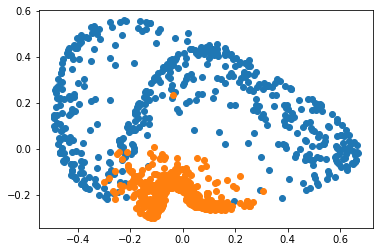

In [80]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

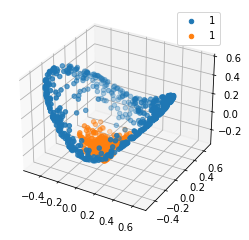

In [81]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data_pca_1[0], data_pca_1[1], data_pca_1[2], label = "1")
ax.scatter(data_pca_2[0], data_pca_2[1], data_pca_2[2], label = "1")
plt.legend()

(500, 1000) (1000, 2)
(500, 1000) (1000, 2)


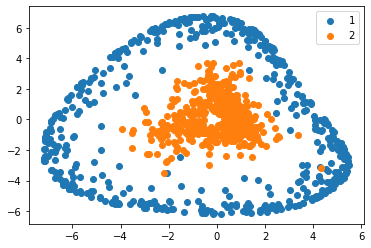

In [82]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

In [65]:
my_kpca.φ.T

DeviceArray([[ 0.37823123, -0.15459603,  0.07877097],
             [ 0.16724375,  0.47069842,  0.05741137],
             [-0.41998023, -0.37313843,  0.45730686],
             ...,
             [-0.04012835, -0.0624739 , -0.15777817],
             [-0.01269677, -0.12116165, -0.2106266 ],
             [-0.01182344, -0.09526106, -0.18427482]], dtype=float32)

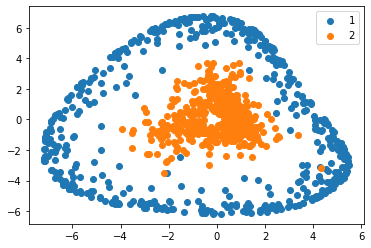

In [83]:
data_1_inv = np.dot(kpca._get_kernel(data_pca_1.T, kpca.X_transformed_fit_), kpca.dual_coef_).T
data_2_inv = np.dot(kpca._get_kernel(data_pca_2.T, kpca.X_transformed_fit_), kpca.dual_coef_).T
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

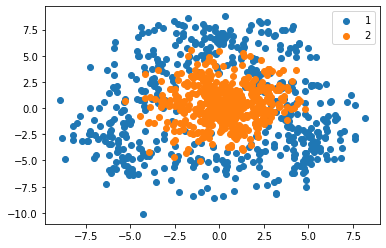

In [87]:
data_1_inv = kpca.inverse_transform(data_pca_1.T)
data_2_inv = kpca.inverse_transform(data_pca_2.T)
plt.scatter(*data_1_inv.T, label = "1")
plt.scatter(*data_2_inv.T, label = "2")
plt.legend()

In [89]:
import sklearn
sklearn.__version__

'0.24.1'